In [1]:
import pandas as pd

df = pd.read_parquet('data/preprocessed.parquet')

In [2]:
df.shape

(4922564, 12)

In [3]:
df.head()

,Bwd Packet Length Std,Bwd Packet Length Max,Packet Length Std,Packet Length Variance,Bwd Packet Length Mean,Avg Bwd Segment Size,Packet Length Max,Avg Packet Size,Init Fwd Win Bytes,Packet Length Mean,Idle Std,ClassLabel
0,119.511505,207.0,107.527443,11562.151367,103.5,103.5,233.0,81.636360,8192,74.833336,0.0,0
1,884.500610,1532.0,547.842529,300131.437500,766.0,766.0,1532.0,286.153839,8192,265.714294,0.0,0
2,782.347229,1518.0,684.968994,469182.531250,508.0,508.0,1552.0,412.133331,8192,386.375000,0.0,0
3,814.063904,1410.0,689.943359,476021.875000,705.0,705.0,1410.0,512.000000,8192,469.333344,0.0,0
4,0.000000,6.0,0.000000,0.000000,6.0,6.0,6.0,9.000000,2053,6.000000,0.0,0


In [4]:
df.dtypes

Bwd Packet Length Std     float32
Bwd Packet Length Max     float64
Packet Length Std         float32
Packet Length Variance    float32
Bwd Packet Length Mean    float32
Avg Bwd Segment Size      float32
Packet Length Max         float64
Avg Packet Size           float32
Init Fwd Win Bytes          int32
Packet Length Mean        float32
Idle Std                  float32
ClassLabel                  int64
dtype: object

In [5]:
min_count = df['ClassLabel'].value_counts().min()
df['ClassLabel'].value_counts(), min_count

(ClassLabel
 0    4099806
 3     575152
 1     144448
 2     103158
 Name: count, dtype: int64,
 np.int64(103158))

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['ClassLabel'], axis=1)
y = df['ClassLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3445794, 11), (1476770, 11), (3445794,), (1476770,))

In [7]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [8]:
numerical_cols = X.select_dtypes(include='number').columns.tolist()
numerical_cols

['Bwd Packet Length Std',
 'Bwd Packet Length Max',
 'Packet Length Std',
 'Packet Length Variance',
 'Bwd Packet Length Mean',
 'Avg Bwd Segment Size',
 'Packet Length Max',
 'Avg Packet Size',
 'Init Fwd Win Bytes',
 'Packet Length Mean',
 'Idle Std']

In [12]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SciPipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import os

allocated_cpus = os.cpu_count() // 2

scaling_transformer = SciPipeline(
    steps=[("scaler", MinMaxScaler(feature_range=(0, 1)))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("scaling_transformer", scaling_transformer, numerical_cols),
    ],
    remainder="passthrough",  # ensures other columns, if any, are not dropped
)

pipeline = ImbPipeline(
    [
        ("preprocessor", preprocessor),
        ("under", RandomUnderSampler(random_state=69, sampling_strategy="majority")),
        ("classifier", LogisticRegression(n_jobs=allocated_cpus)),
    ]
)

# Define parameter grid for GridSearchCV
param_grid = [
    {
        "classifier": [
            LogisticRegression(
                n_jobs=allocated_cpus,
            )
        ],
        "classifier__penalty": ["l1", "l2", 'elasticnet'],
    },
]

In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=3, random_state=69, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='f1_macro', n_jobs=os.cpu_count()//2, verbose=3)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
grid_search.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\neucl\Dev\AIT\CP_Projects\ID-LD-ML\project-env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\neucl\Dev\AIT\CP_Projects\ID-LD-ML\project-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\neucl\Dev\AIT\CP_Projects\ID-LD-ML\project-env\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\neucl\Dev\AI

Best parameters found:  {'classifier': LogisticRegression(n_jobs=6), 'classifier__penalty': 'l2'}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Bwd Packet Length Std',
                                                   'Bwd Packet Length Max',
                                                   'Packet Length Std',
                                                   'Packet Length Variance',
                                                   'Bwd Packet Length Mean',
                                                   'Avg Bwd Segment Size',
                                                   'Packet Length Max',
                                                   'Avg Packet Size',
                                                   'Init Fwd Win Bytes',
                                                   'Packet Length Mean',
                                                   'Idle Std'])])),
                ('under',
                 RandomUnderSampler(random_state=69,
                                    sampling_strategy='majority')),
                ('classifier', LogisticRegression(n_jobs=6))])

In [14]:
import json
from sklearn.metrics import classification_report

y_pred = grid_search.best_estimator_.predict(X_test)
print(json.dumps(classification_report(y_test, y_pred, output_dict=True), indent=4))

{
    "0": {
        "precision": 0.9827725395220516,
        "recall": 0.1019630835235483,
        "f1-score": 0.18475749556484172,
        "support": 1229749.0
    },
    "1": {
        "precision": 0.08247894382335787,
        "recall": 0.9711662967073622,
        "f1-score": 0.15204504770299793,
        "support": 43248.0
    },
    "2": {
        "precision": 0.2917043508380318,
        "recall": 0.9756709789534659,
        "f1-score": 0.4491289405072292,
        "support": 31074.0
    },
    "3": {
        "precision": 0.22783200365209452,
        "recall": 0.9709841979397681,
        "f1-score": 0.3690662088773708,
        "support": 172699.0
    },
    "accuracy": 0.24742918667091016,
    "macro avg": {
        "precision": 0.3961969594588839,
        "recall": 0.7549461392810362,
        "f1-score": 0.2887494231631099,
        "support": 1476770.0
    },
    "weighted avg": {
        "precision": 0.8535800275356554,
        "recall": 0.24742918667091016,
        "f1-score": 0.

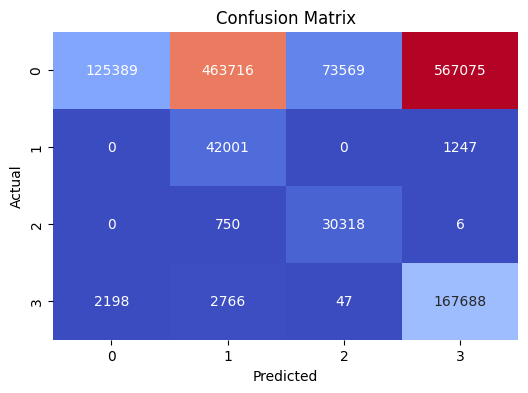

In [15]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

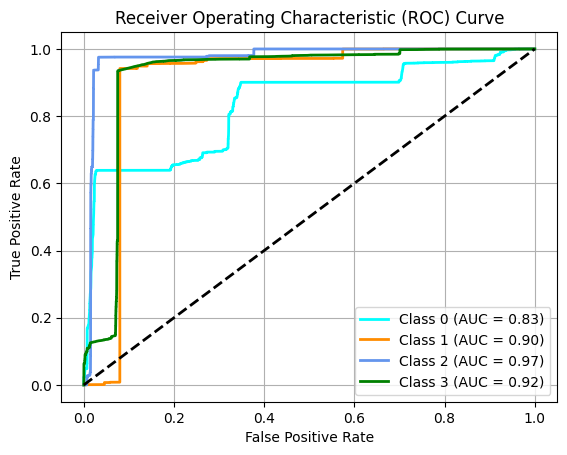

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np


n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

y_score = grid_search.best_estimator_.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [17]:
import pickle
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

In [18]:
with open('models/best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [19]:
data_to_predict = X_test.iloc[991].tolist()

In [20]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [21]:
data_to_predict_df = pd.DataFrame([data_to_predict], columns=X_test.columns)
loaded_model.predict(data_to_predict_df)

array([0])

In [22]:
y_test.iloc[991]

np.int64(0)

In [23]:
X_test.columns

Index(['Bwd Packet Length Std', 'Bwd Packet Length Max', 'Packet Length Std',
       'Packet Length Variance', 'Bwd Packet Length Mean',
       'Avg Bwd Segment Size', 'Packet Length Max', 'Avg Packet Size',
       'Init Fwd Win Bytes', 'Packet Length Mean', 'Idle Std'],
      dtype='object')